In [3]:
import os

train_dir = "./data/train"
train_dogs_dir = f"{train_dir}/dogs"
train_cats_dir = f"{train_dir}/cats"
val_dir = "./data/val"
val_dogs_dir = f"{val_dir}/dogs"
val_cats_dir = f"{val_dir}/cats"

Raw cells only needed to move data into correct directories.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

print(torch.__version__)
plt.ion()  # interactive mode

1.7.1


In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation(5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [11]:
data_dir = "data"
CHECK_POINT_PATH = "checkpoint.tar"
SUBMISSION_FILE = "submission.csv"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)  # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


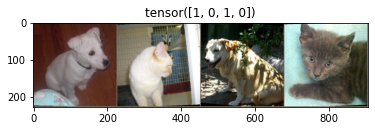

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint=None):
    since = time.time()
    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.0
    else:
        print(
            f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}'
        )
        model.load_state_dict(checkpoint["model_state_dict"])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        best_loss = checkpoint["best_val_loss"]
        best_acc = checkpoint["best_val_accuracy"]
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                if i % 200 == 199:
                    print(
                        "[%d, %d] loss: %.3f"
                        % (epoch + 1, i, running_loss / (i * inputs.size(0)))
                    )
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == "val" and epoch_loss < best_loss:
                print(f"New best model found!")
                print(
                    f"New record loss: {epoch_loss}, previous record loss: {best_loss}"
                )
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best val Acc: {:.4f} Best val loss: {:.4f}".format(best_acc, best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [19]:
model_conv = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/x26393/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
    model_conv, best_val_loss, best_val_acc = train_model(
        model_conv,
        criterion,
        optimizer_conv,
        exp_lr_scheduler,
        num_epochs=3,
        checkpoint=checkpoint,
    )
    torch.save(
        {
            "model_state_dict": model_conv.state_dict(),
            "optimizer_state_dict": optimizer_conv.state_dict(),
            "best_val_loss": best_val_loss,
            "best_val_accuracy": best_val_acc,
            "scheduler_state_dict": exp_lr_scheduler.state_dict(),
        },
        CHECK_POINT_PATH,
    )

checkpoint not found
Epoch 0/2
----------
[1, 199] loss: 0.378
[1, 399] loss: 0.318
[1, 599] loss: 0.312
[1, 799] loss: 0.324
[1, 999] loss: 0.327
[1, 1199] loss: 0.325
[1, 1399] loss: 0.335
[1, 1599] loss: 0.339
[1, 1799] loss: 0.347
[1, 1999] loss: 0.351
[1, 2199] loss: 0.349
[1, 2399] loss: 0.346
[1, 2599] loss: 0.353
[1, 2799] loss: 0.348
[1, 2999] loss: 0.342
[1, 3199] loss: 0.341
[1, 3399] loss: 0.340
[1, 3599] loss: 0.337
[1, 3799] loss: 0.332
[1, 3999] loss: 0.333
[1, 4199] loss: 0.333
[1, 4399] loss: 0.330
[1, 4599] loss: 0.330
[1, 4799] loss: 0.332
[1, 4999] loss: 0.332
[1, 5199] loss: 0.332
[1, 5399] loss: 0.334
[1, 5599] loss: 0.332
train Loss: 0.3316 Acc: 0.8795
[1, 199] loss: 0.075
[1, 399] loss: 0.084
val Loss: 0.0906 Acc: 0.9675
New best model found!
New record loss: 0.09055290417642482, previous record loss: inf
Epoch 1/2
----------
[2, 199] loss: 0.274
[2, 399] loss: 0.326
[2, 599] loss: 0.313
[2, 799] loss: 0.318
[2, 999] loss: 0.324
[2, 1199] loss: 0.317
[2, 1399] l

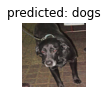

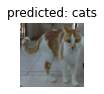

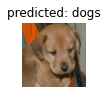

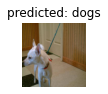

In [28]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis("off")
        ax.set_title("predicted: {}".format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        if images_so_far == num_images:
            model.train(mode=was_training)
            return
    model.train(mode=was_training)


visualize_model(model_conv)
plt.ioff()
plt.show()

In [29]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224, 224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(
        out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    )
    return out

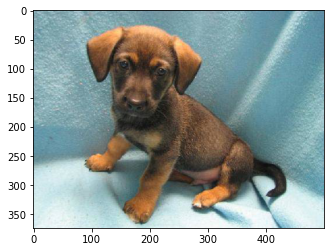

In [31]:
from PIL import Image

test_data_dir = f"{data_dir}/val"
test_data_files = os.listdir(test_data_dir)
im = Image.open(f"{test_data_dir}/{test_data_files[0]}")
plt.imshow(im)

In [32]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [54]:
model_conv(minibatch)

tensor([[-1.8619,  1.9405]], grad_fn=<AddmmBackward>)

In [55]:
softMax = nn.Softmax(dim=1)
preds = softMax(model_conv(minibatch))
preds

tensor([[0.0218, 0.9782]], grad_fn=<SoftmaxBackward>)

In [56]:
def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim=1)
    preds = softMax(model(batch))
    return preds[0, 1].item()

In [57]:
def test_data_from_fname(fname):
    im = Image.open(f"{test_data_dir}/{fname}")
    return apply_test_transforms(im)

In [62]:
model

NameError: name 'model' is not defined

In [65]:
torch.save(model_conv, "pred_catdog.pt")